# Geography/Media/Politics/Wealth

General trends and stats for geography, media, politics, and wealth.


## Setup


In [79]:
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Helpers


In [80]:
def determine_dominant_affiliation(row):
    # Convert percentage strings to integers and determine dominant political affiliation
    rep = int(row["republican_lean_rep"].rstrip("%"))
    dem = int(row["democrat_lean_dem"].rstrip("%"))
    if rep > dem:
        return "Republican"
    elif dem > rep:
        return "Democrat"
    else:
        return "No dominant affiliation"


# Load datasets and ensure columns are in snake_case
def load_and_rename(path, rename_map=None):
    df = pd.read_csv(path)
    if rename_map:
        df.rename(columns=rename_map, inplace=True)
    else:
        df.columns = [re.sub(r"(?<!^)(?=[A-Z])", "_", c).lower() for c in df.columns]
    return df

## Data


In [81]:
# Load datasets
companies_df = load_and_rename("./datasets/inc_5000_companies.csv")
party_affiliations_df = pd.read_html("./datasets/pew_party_affiliation.html")[0]
billionaires_df = load_and_rename("./datasets/billionaires.csv")
city_state_df = load_and_rename("./datasets/city_state.csv")
state_abbreviations_df = load_and_rename("./datasets/state_abbreviations.csv")
population_by_state_df = load_and_rename(
    "./datasets/us_pop_by_state.csv", rename_map={"2020_census": "population"}
)

In [82]:
# Adjust party_affiliations_df to use snake_case
party_affiliations_df.columns = [
    "state",
    "republican_lean_rep",
    "no_lean",
    "democrat_lean_dem",
    "sample_size",
]

# Filter for US billionaires
us_billionaires_df = billionaires_df[
    billionaires_df["country_of_citizenship"] == "United States"
].copy()

# Rename and select relevant columns for population DataFrame
population_by_state_df = population_by_state_df[["rank", "state", "population"]].copy()
population_by_state_df.rename(columns={"rank": "population_rank"}, inplace=True)

# Merge billionaires data with city-state information
us_billionaires_df = us_billionaires_df.merge(city_state_df, on="city", how="left")
us_billionaires_df.rename(columns={"state_x": "state"}, inplace=True)
us_billionaires_df.drop(columns=["state_y"], inplace=True)
# Count billionaires by state
billionaires_by_state_df = (
    us_billionaires_df.groupby("state").size().reset_index(name="billionaire_count")
)

# Proceed with merging party affiliations with billionaire counts, ensuring column names are consistent
political_wealth_df = party_affiliations_df.merge(billionaires_by_state_df, on="state")

# Apply the function to determine dominant political affiliation
political_wealth_df["dominant_affiliation"] = political_wealth_df.apply(
    determine_dominant_affiliation, axis=1
)

# Prepare the DataFrame with state, billionaire count, and dominant affiliation
wealth_by_state_affiliation_df = political_wealth_df[
    ["state", "billionaire_count", "dominant_affiliation"]
].copy()

# Sort by billionaire count, descending
wealth_by_state_affiliation_df.sort_values(
    by="billionaire_count", ascending=False, inplace=True
)

# Merge major companies count with wealth and political affiliation data
wealth_by_state_affiliation_df = wealth_by_state_affiliation_df.merge(
    major_companies_by_state_df, on="state", how="left"
)

# Merge with population data
wealth_by_state_affiliation_df = wealth_by_state_affiliation_df.merge(
    population_by_state_df, on="state", how="left"
)

# Calculate billionaires per capita and per million
wealth_by_state_affiliation_df["billionaires_per_capita"] = (
    wealth_by_state_affiliation_df["billionaire_count"]
    / wealth_by_state_affiliation_df["population"]
)
wealth_by_state_affiliation_df["billionaires_per_million"] = (
    wealth_by_state_affiliation_df["billionaires_per_capita"] * 1e6
)

wealth_by_state_affiliation_df

,state,billionaire_count,dominant_affiliation,abbreviation,major_company_count,population_rank,population,billionaires_per_capita,billionaires_per_million
0,California,159,Democrat,CA,712,1.0,39538223,4.021425e-06,4.021425
1,New York,118,Democrat,NY,300,4.0,20201249,5.841223e-06,5.841223
2,Florida,90,Democrat,FL,385,3.0,21538187,4.178625e-06,4.178625
3,Texas,70,Democrat,TX,467,2.0,29145505,2.401743e-06,2.401743
4,Illinois,24,Democrat,IL,241,6.0,12801989,1.874709e-06,1.874709
5,Massachusetts,20,Democrat,MA,133,15.0,7029917,2.844984e-06,2.844984
6,Pennsylvania,19,Democrat,PA,172,5.0,13002700,1.461235e-06,1.461235
7,Nevada,18,Democrat,NV,33,32.0,3104614,5.797822e-06,5.797822
8,Georgia,17,No dominant affiliation,GA,219,8.0,10711908,1.587019e-06,1.587019
9,Washington,13,Democrat,WA,101,13.0,7705281,1.687155e-06,1.687155


In [83]:
wealth_by_state_affiliation_df.columns

Index(['state', 'billionaire_count', 'dominant_affiliation', 'abbreviation',
       'major_company_count', 'population_rank', 'population',
       'billionaires_per_capita', 'billionaires_per_million'],
      dtype='object')

## Billionaires by State


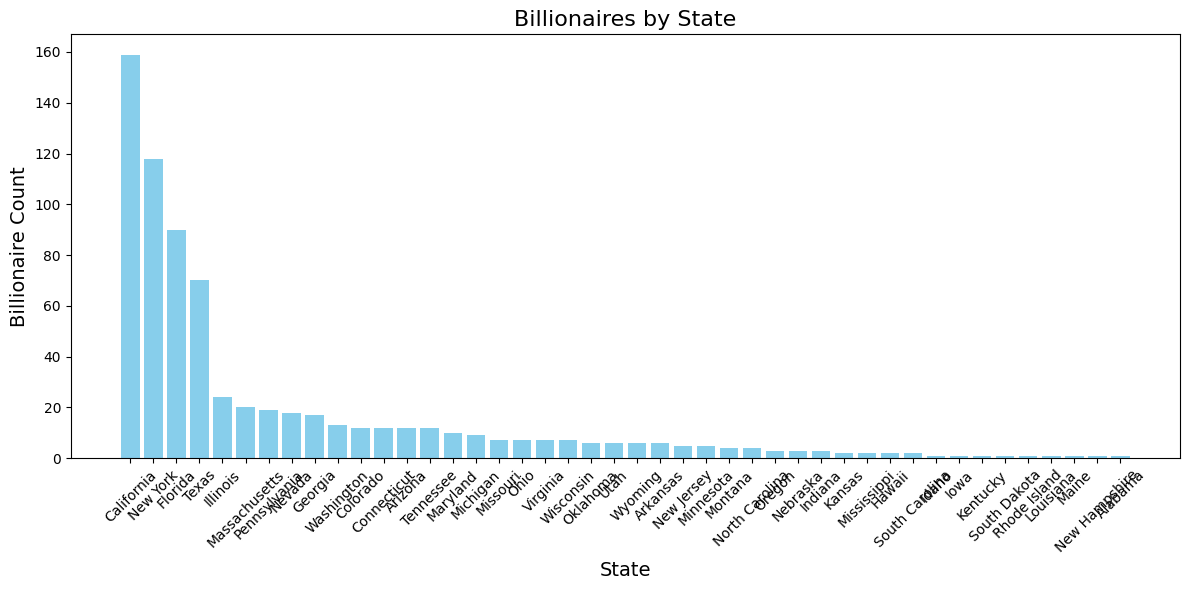

In [84]:
# Billionaires by State
plt.figure(figsize=(12, 6))
plt.bar(
    wealth_by_state_affiliation_df["state"],
    wealth_by_state_affiliation_df["billionaire_count"],
    color="skyblue",
)
plt.xlabel("State", fontsize=14)
plt.ylabel("Billionaire Count", fontsize=14)
plt.title("Billionaires by State", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Billionaires per Million People by State


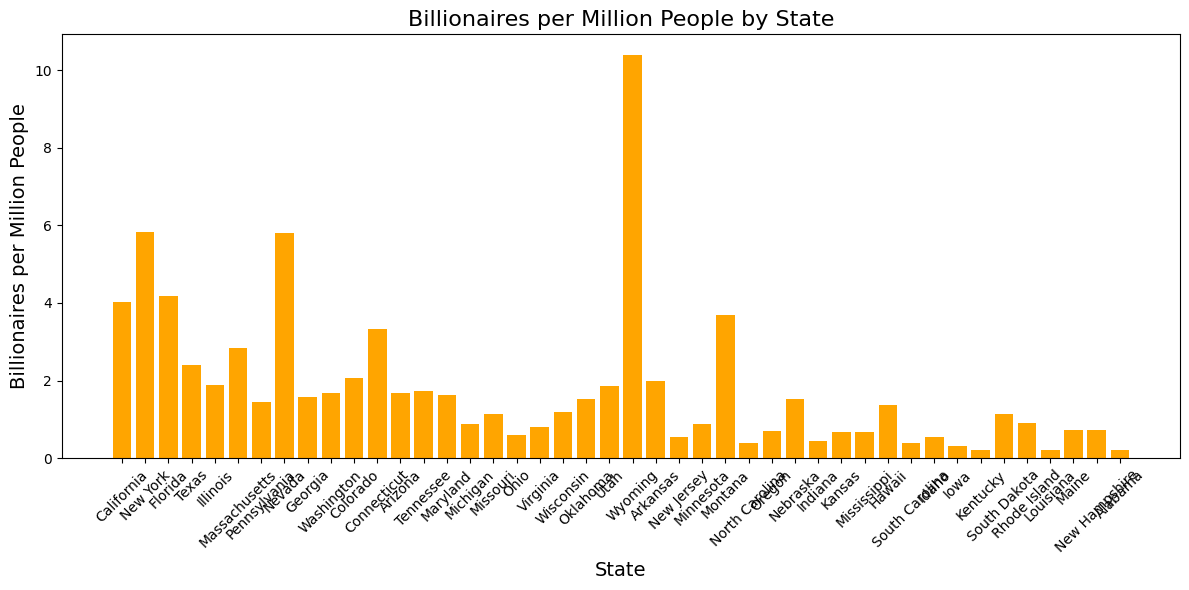

In [85]:
# Billionaires per Million People by State
plt.figure(figsize=(12, 6))
plt.bar(
    wealth_by_state_affiliation_df["state"],
    wealth_by_state_affiliation_df["billionaires_per_million"],
    color="orange",
)
plt.xlabel("State", fontsize=14)
plt.ylabel("Billionaires per Million People", fontsize=14)
plt.title("Billionaires per Million People by State", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Major Companies by State


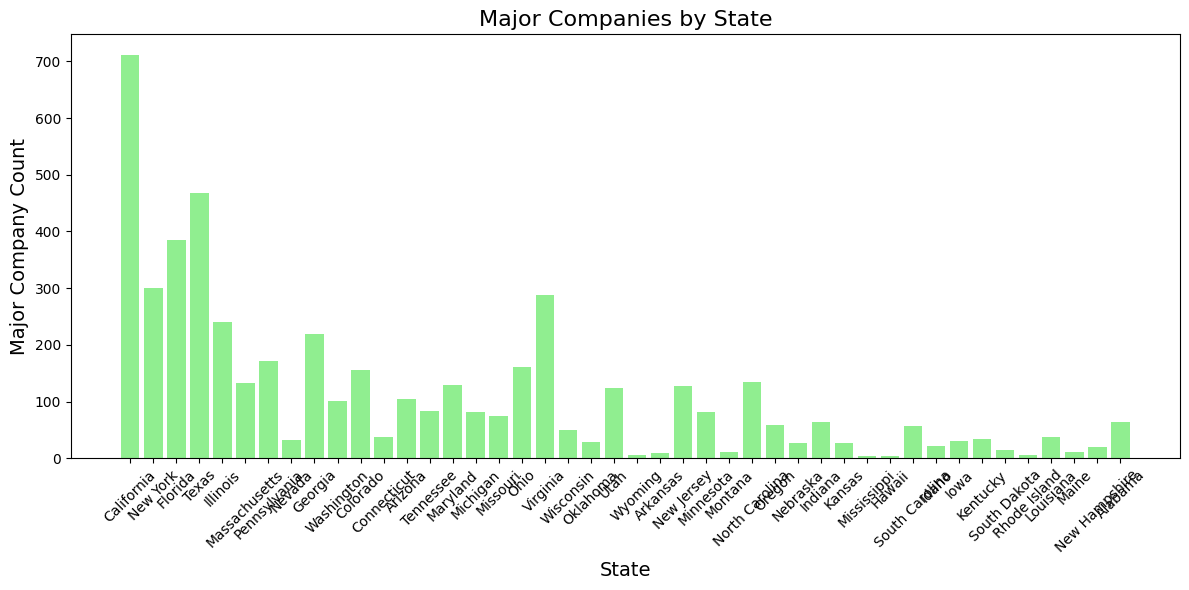

In [86]:
# Major Companies by State
plt.figure(figsize=(12, 6))
plt.bar(
    wealth_by_state_affiliation_df["state"],
    wealth_by_state_affiliation_df["major_company_count"],
    color="lightgreen",
)
plt.xlabel("State", fontsize=14)
plt.ylabel("Major Company Count", fontsize=14)
plt.title("Major Companies by State", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Relationships between billionaires, companies, and populations


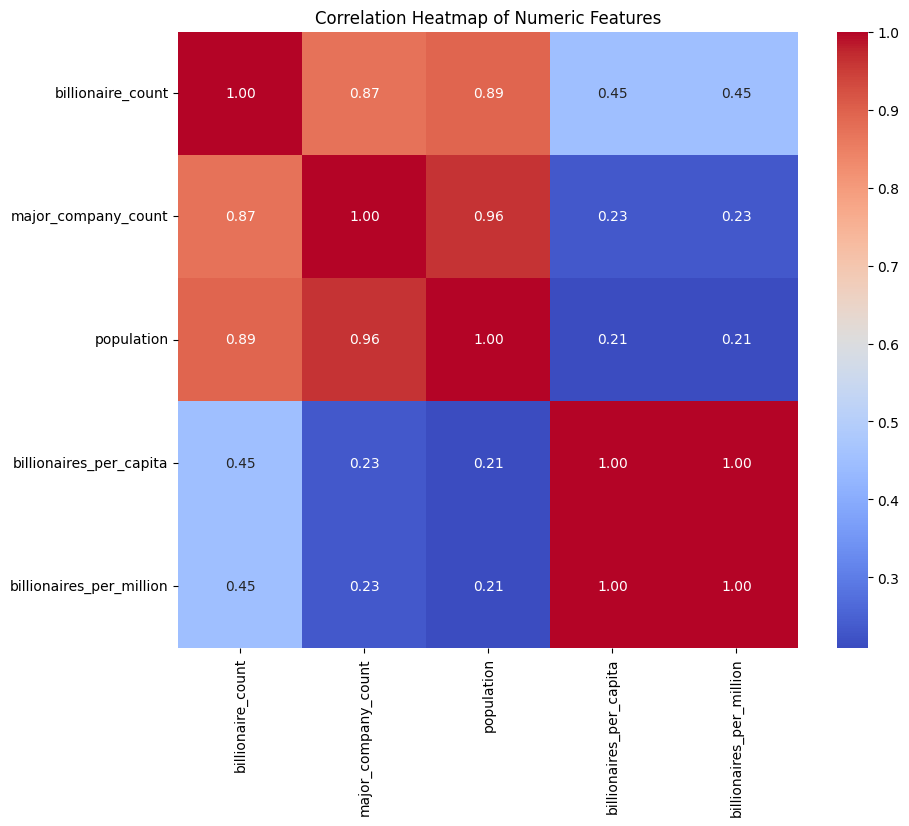

In [87]:
# Relationships between billionaires, companies, and populations
corr = wealth_by_state_affiliation_df[
    [
        "billionaire_count",
        "major_company_count",
        "population",
        "billionaires_per_capita",
        "billionaires_per_million",
    ]
].corr()
plt.figure(figsize=(10, 8))
plt.title("Correlation Heatmap of Numeric Features")
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

## Predicting Billionaire Counts


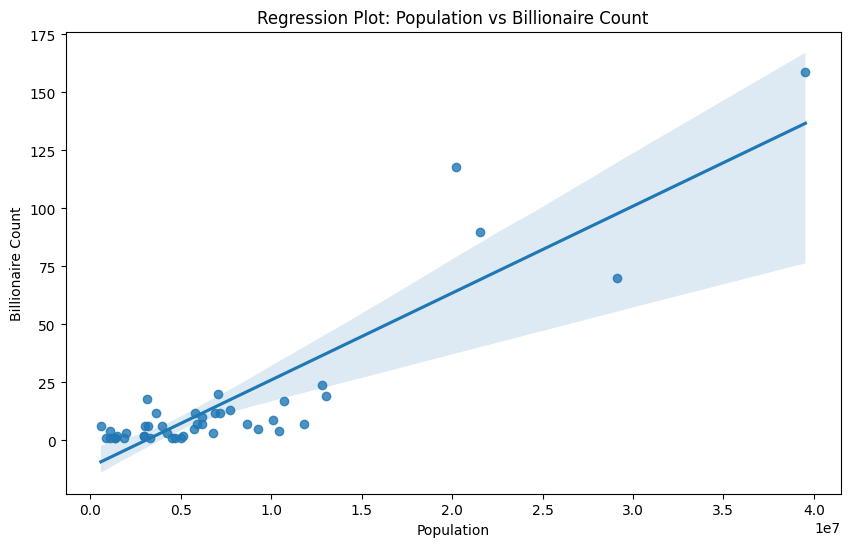

In [88]:
# Regression plot between population and billionaire_count to see any linear relationship
plt.figure(figsize=(10, 6))
sns.regplot(x="population", y="billionaire_count", data=wealth_by_state_affiliation_df)
plt.title("Regression Plot: Population vs Billionaire Count")
plt.xlabel("Population")
plt.ylabel("Billionaire Count")
plt.show()